## My take on your analysis
This notebook illustrates some of my suggestions for how to structure your code.
I have tried to follow the principle of "Separation of Concerns", by making functions
that perform specialized jobs. That way it is easier to adapt and maintain.
The functions are located in the file called `functions`. I have tried to add some
documentation.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

from functions import graphTemplate, toLongForm, graphAllGrowthCurves, combineReplicates, graphCombinedGrowthCurves, graphCurveFitting, richardsCurveFitting, curveFitOnPlate

## Defining a template
From what I can understand, all the important information and relationships
are stoded in your plate design. By using a template as the one below, the
code can be significantly simplified. How to combine the wells in order to
calculate means and standard deviations can be inferred from the well names.
I chose to use completely generic names to simplify the code a bit.

It will be significantly faster to adapt a template for your particular
plate design, than to go in and modify the code for each plate.

You can use generic names or more detailed names - both will work.

**Note**: The name 'Blank' has a special meaning, and is interpreted
as a blank sample.

The plate coordinates in the template are in this orientation:

```
    1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12
  ---------------------------------------------------
A |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
B |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
C |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
D |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
E |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
F |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
G |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
H |   |   |   |   |   |   |   |   |   |    |    |
  ---------------------------------------------------
```

## Load and visualize the plate layout
Load template defined in CSV, and convert it to a list of lists.
Using `nan`s instead of `None`s leads to unused wells being shown as black, which looks nice :)

**Note**: The code expects the template to be a list of lists, so I have to "un-dataframe" it by calling the `.values.tolist()` method.

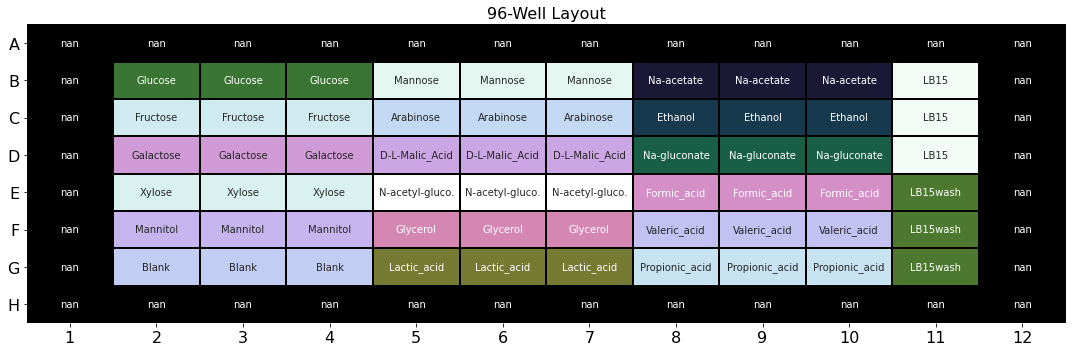

<AxesSubplot:title={'center':'96-Well Layout'}>

In [2]:
# Load template from CSV file, and convert to a list
template = pd.read_csv(os.path.join('Templates', 'Template_pseudomonas.csv'), index_col=0).values.tolist()
graphTemplate(template)

## Load and manipulate data
Combining the replicates is based on identifying similar `Group` IDs defined in the template, and grouping them with matching `Time_hours` values. See the `combineReplicates` function for more details.

If you standardize the file naming, then it is easy to automatically extract relevant parameters that can be added to the dataframe.
(I don't fully understand what the different parts of the filename refers to, you will get the idea :) ):

`filename = param1_param2_param3_param4.csv`

**Note**: No outlier handling is being done.

**Note**: The last `_` makes it easy to `split` the text on underscores to unpack the parameters

In [3]:
wideFormData = 'Pseudomonas_Sp_mr4-99_Round1_.csv'
param1, param2, param3, param4, extension = wideFormData.split('_')
wideForm = pd.read_csv(os.path.join('Datasets', wideFormData), delimiter=';')
longForm = toLongForm(wideForm, template)
combined = combineReplicates(longForm)

# Add parameters to the combined dataframe
combined['Parameter1'] = param1
combined['Parameter2'] = param2
combined['Parameter3'] = param3
combined['Parameter4'] = param4

## Plotting all the growth curves
The `longForm` data frame contains growth curves from all wells. The `graphAllGrowthCurves` function plots all of these in a grid, and color codes the curves based on the `Group` they belong to.

This can serve as a quick check of what the curves look like.

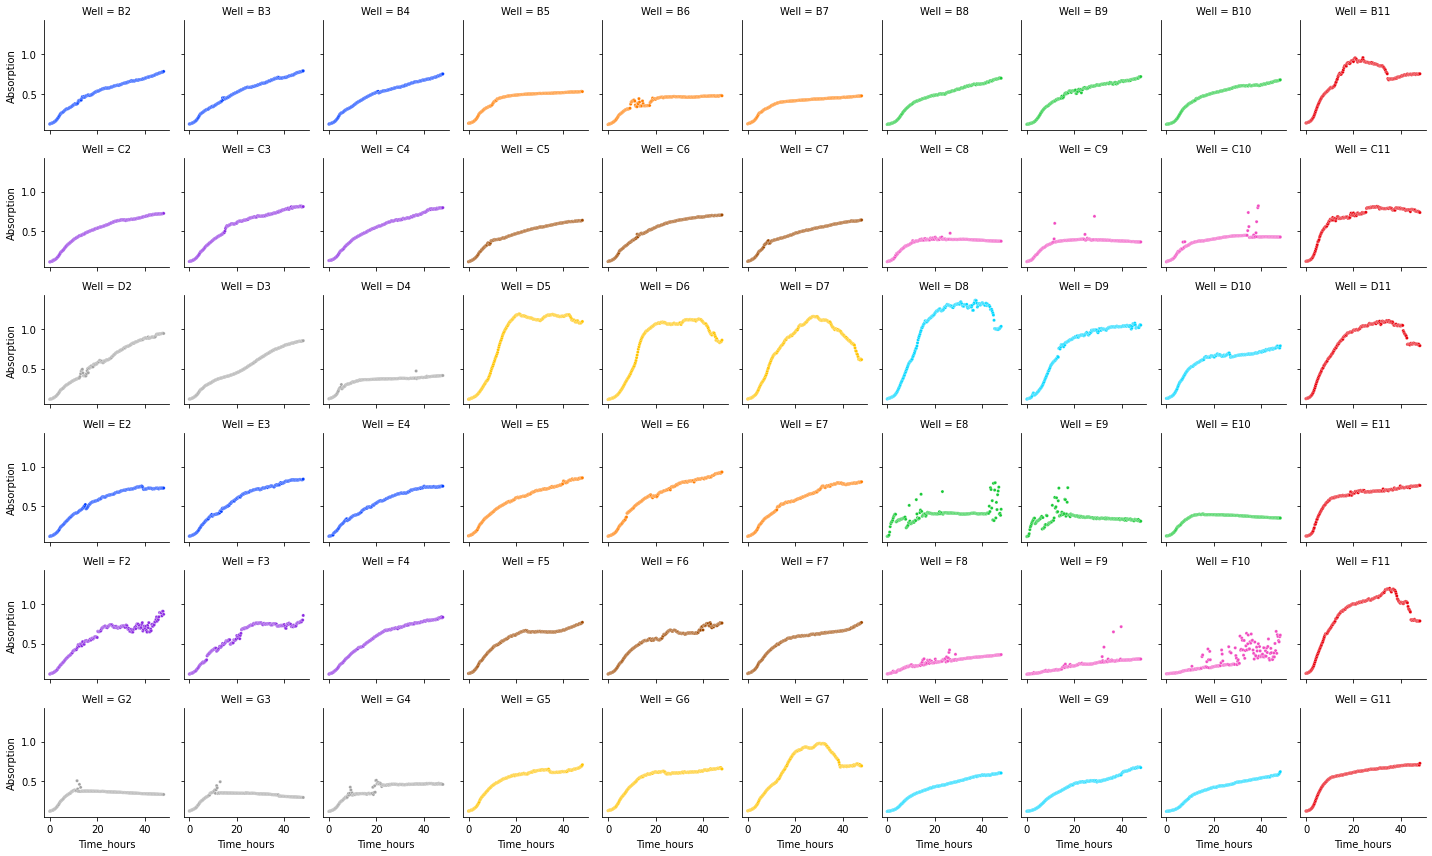

In [4]:
graphAllGrowthCurves(longForm, col_wrap=10, savefig=False, show=True)

## Plotting the average growth curves
The `graphCombinedGrowthCurves` function plots the average growth curves. 

By setting `augment=True`, the function also adds error bands based on the standard deviations (mean $\pm$ StDev) and overlays all the average curves with the average blank curves. 

By setting `log=True`, the function uses the log2 transformed averages and errors.

**Note**: I never subtracted the blanks from the averages (which you did in your code).

**Note**: Log transformed error boundaries were calculated like this:

$$
\mathrm{Upper} = \log_2 (\mathrm{Mean} + \mathrm{StDev})
$$

and

$$
\mathrm{Lower} = \log_2 (\mathrm{Mean} - \mathrm{StDev})
$$

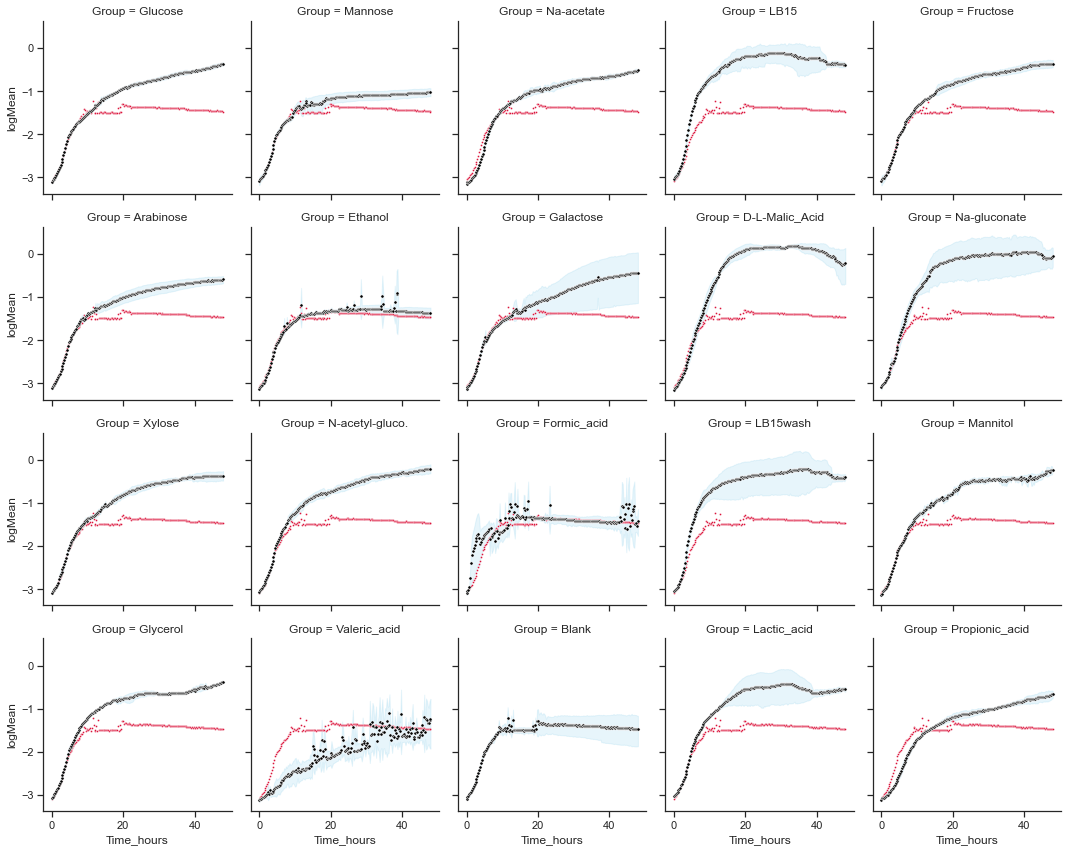

In [5]:
graphCombinedGrowthCurves(combined, col_wrap=5, log=True, augment=True, savefig=False, show=True)

## Fitting a generalized logistic curve
I have added a function which fits a so-called Richard's curve (generalized logistic function) to your growth curves. The Richard's curve implemented looks like this

$$
f(t) = L + \frac{U - L}{\left(1 + \frac{1}{2}e^{-kt}\right)^{1/\nu}}
$$

where

- $t$: Time series data for the x axis (`Time_hours` in your data sets)
- $L$: Lower asymptotic limit
- $U$: Upper asymptotic limit
- $k$: maximum growth rate
- $\nu$: An "asymmetry" paramter, which controls whether the midpoint is closer to the lower or upper asymptote.

More information on Wikipedia: https://en.wikipedia.org/wiki/Generalised_logistic_function

The four parameters are fitted in a least-square manner. It is important to provide reasonable starting values for these paramters in order for the algorothm to converge to a fit that makes sense. These initial parameters are passed in via the `p0` keyword (see the function definitions).  Current initial values:

- $L$: `min(y)`
- $U$: `max(y)`
- $k$: 0.5
- $\nu$: 0.5  (midpoint closer to the lower asymptote)

Additionally, in order to try and make the fit more robust, I have added some constraints which limit the values the parameters are allowed to take. Currently the following bounds are used (in orer: $U$, $L$, $k$, $\nu$):

- Lower bounds: `(max(y) - 0.5, min(y) - 0.05, 0.01, 0.01)`
- Upper bounds: `(max(y) + 0.5, min(y) + 0.05, 5.0, 10.0)`

It is therefore baked into the fitting algorithm that each growth curve ends close to the pleateau, and starts off close to the "zero" growth level. You may have to tweak these in the future.

After doing some tests, I have a few observations:

- it seems to me that a rather good fit happens when your growth curve has reached the plateau. If not reached, then often the fit cannot be used to give an accurate estimate of the maximum growth rate of the plateau. See for example `Glucose`: The fit is bad both in all regions of the curve. Then look at `Ethanol`, where the fit is able to describe the pleateau, the exponential growth region, and the beginning quite well.
- Noise does not affect the fitted cirve very much. For example, `Formic_acid` has a quite good fit, despite rather noisy data.

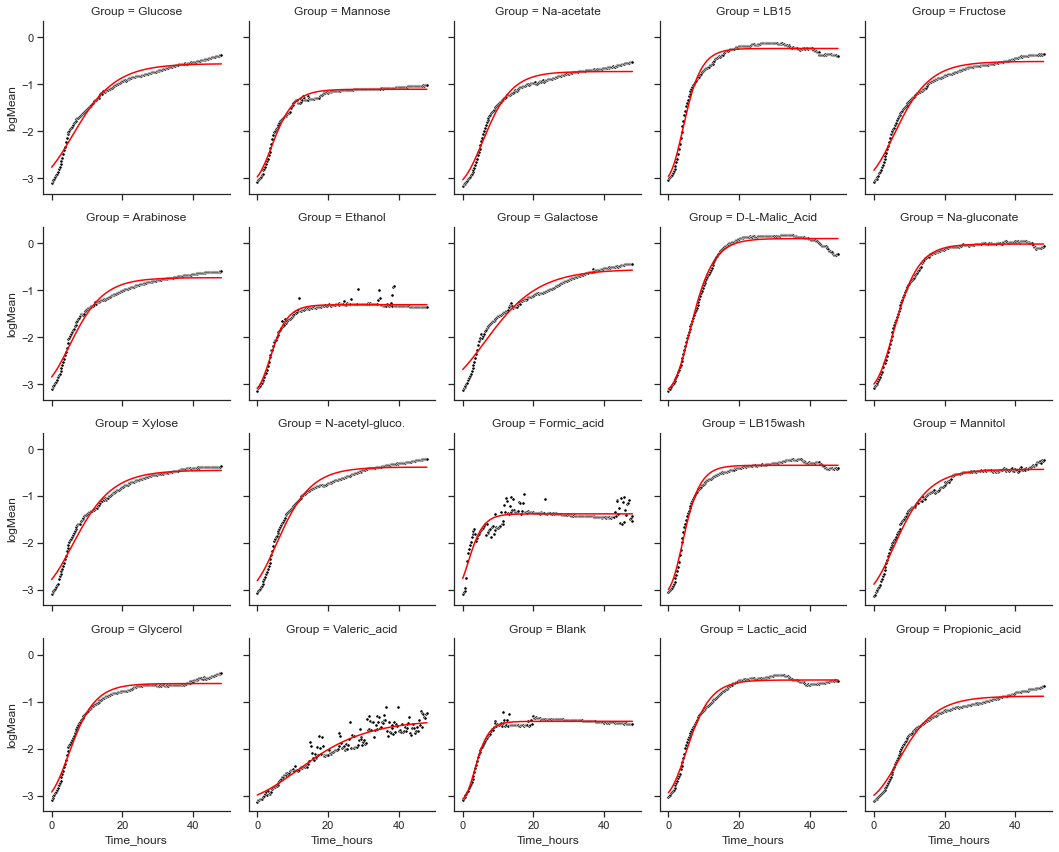

In [6]:
ax = graphCurveFitting(combined, col_wrap=5, savefig=False, show=True)

## Plot optimized curve parameters
I think the most interesting features from the curve fitting are the plateau and the maximum growth rate.
These are easy to get out from the model, since Richard's curve contains these parameters directly ($U$ and $k$).

The function `curveFitOnPlate` performs the curve fitting on all groups in the combined dataframe, 
and returns the generic function used for the fitting and a dataframe holding all the patameters.
All the the fitted curves can be retrieved just from the returned function and the returned parameters
(see example below).

The code for the plotting has not been put into the `functions` file. If this kind of plot is something you want to do often, then it would be a good idea to make it a function.

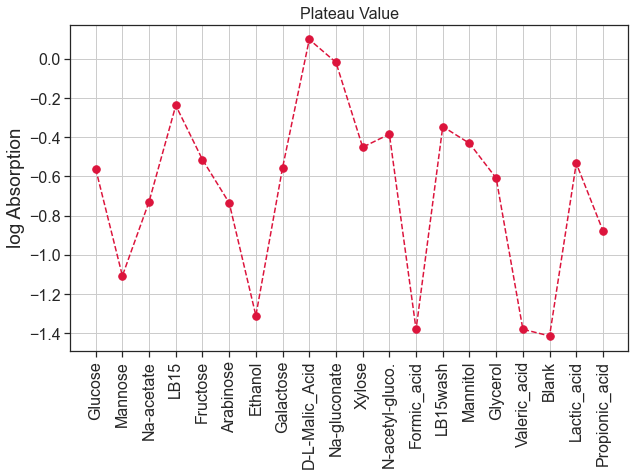

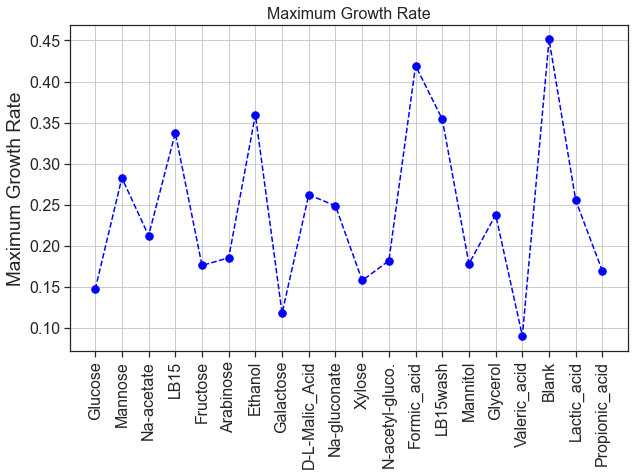

In [7]:
func, params = curveFitOnPlate(combined)

fig, ax = plt.subplots(figsize=(10, 6))
FS = 16
ax.plot(params.Group, params.U, marker='.', color='crimson', ms=15, ls='--')
ax.set_ylabel('log Absorption', fontsize=FS+3)
ax.tick_params(axis='x', rotation=90, labelsize=FS)
ax.tick_params(axis='y', labelsize=FS)
ax.set_title('Plateau Value', fontsize=FS)
ax.grid()

fig, ax = plt.subplots(figsize=(10, 6))
FS = 16
ax.plot(params.Group, params.k, marker='.', color='blue', ms=15, ls='--')
ax.set_ylabel('Maximum Growth Rate', fontsize=FS+3)
ax.tick_params(axis='x', rotation=90, labelsize=FS)
ax.tick_params(axis='y', labelsize=FS)
ax.set_title('Maximum Growth Rate', fontsize=FS)
ax.grid()

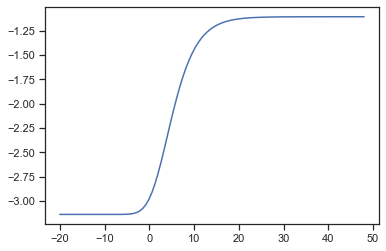

In [8]:
# Example on how to retrieve a fitted function from the returned function and parameters
# Use Mannose as an example
# Dataframe is the one with combined replicates
# (order matters in the optimized parameters (popt))
func, params = curveFitOnPlate(combined)
group = 'Mannose'
popt = params.loc[params.Group == group].values.tolist()[0][1:]
xs = np.linspace(-20, 48, 100)
ys = func(xs, *popt)
plt.plot(xs, ys)